In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_MOUSE"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-VDJmouse-IGH_MOUSE-after-reassignment.csv']

In [3]:
pt_file="20201116-RUN40-DataSheet.csv"
run = "run40"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run40-similarity-IGH_MOUSE.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,A11-Bh_S9,ACGTACGT,CARGEAMDYWGQGTSVT,48096,390,IGHV1-12,IGHJ4,316,0.006570,95.824036,19.807009
1,A11-Bh_S9,ACGTACGT,CTRGEAMDYWGQGTSVT,225,103,IGHV1-12,IGHJ4,12,0.053333,0.448279,5.231082
2,A11-Bh_S9,ACGTACGT,TSVT,145,74,IGHV1-12,IGHJ4,0,0.000000,0.288891,3.758253
3,A11-Bh_S9,ACGTACGT,CARGGAMDYWGQGTSVT,91,54,IGHV1-12,IGHJ4,1,0.010989,0.181304,2.742509
4,A11-Bh_S9,ACGTACGT,CAGGEAMDYWGQGTSVT,80,50,IGHV1-12,IGHJ4,1,0.012500,0.159388,2.539360


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
59148,BN314-Bh_S240,CARRLYYGKTDYFDYWGQGTTLT,1112,193,3,0.002698,10.730483,2.815053
59121,BN314-Bh_S240,CARRFDYWGQGTTLT,371,119,1,0.002695,3.580044,1.735706
59251,BN314-Bh_S240,CARSYYGTYWGQGTTLT,153,84,0,0.000000,1.476406,1.225204
58904,BN314-Bh_S240,CARGDYDGYYFDYWGQGTTLT,151,73,0,0.000000,1.457107,1.064761
58950,BN314-Bh_S240,CARGGYWSYWGQGTTLT,149,77,0,0.000000,1.437808,1.123104


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,Group,HEK cells,RACE,Constant,ChainOrig
0,N711_S502,A11-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S9,...,mouse,BCRh,A1,Spleen-day21,no,VERA,yes,no,no,mBCRh
1,N712_S502,A12-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10,...,mouse,BCRh,A2,Spleen-day21,no,VERA,yes,no,no,mBCRh
2,N714_S502,A13-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S11,...,mouse,BCRh,A3,Spleen-day21,no,VERA,yes,no,no,mBCRh
3,N715_S502,A14-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S12,...,mouse,BCRh,A4,Spleen-day21,no,VERA,yes,no,no,mBCRh
4,N716_S502,A15-Bh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S13,...,mouse,BCRh,A5,Spleen-day21,no,VERA,yes,no,no,mBCRh


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,A11-Bh_S9,A1
1,A12-Bh_S10,A2
2,A13-Bh_S11,A3
3,A14-Bh_S12,A4
4,A15-Bh_S13,A5


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,BN314-Bh_S240,CARRLYYGKTDYFDYWGQGTTLT,1112,193,3,0.002698,10.730483,2.815053,BN3
1,BN314-Bh_S240,CARRFDYWGQGTTLT,371,119,1,0.002695,3.580044,1.735706,BN3
2,BN314-Bh_S240,CARSYYGTYWGQGTTLT,153,84,0,0.000000,1.476406,1.225204,BN3
3,BN314-Bh_S240,CARGDYDGYYFDYWGQGTTLT,151,73,0,0.000000,1.457107,1.064761,BN3
4,BN314-Bh_S240,CARGGYWSYWGQGTTLT,149,77,0,0.000000,1.437808,1.123104,BN3


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                                          A1                          \
Sample                                    A11-Bh_S9 A131-Bh_S19 A138-Bh_S68   
cdr3pep                                                                       
AARGEAMDYWGQGTSVT                               0.0         0.0         0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT       0.0         0.0         0.0   
AGDFDYWGQGTTLT                                  0.0         0.0         0.0   
AGYWGQGTTLT                                     0.0         0.0         0.0   
AIIYWGQGTSVT                                    0.0         0.0         0.0   

Patient                                                              \
Sample                                    A143-Bh_S115 A150-Bh_S241   
cdr3pep                                                               
AARGEAMDYWGQGTSVT                                  0.0          0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT          0.0          0.0   
AGDFDYWGQGTTLT                                     0.0          0.0   
AGYWGQGTTLT                                        0.0          0.0   
AIIYWGQGTSVT                                       0.0          0.0   

Patient                                                                      \
Sample                                    A16-Bh_S35 A21-Bh_S61 A26-Bh_S131   
cdr3pep                                                                       
AARGEAMDYWGQGTSVT                                0.0        0.0         0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT        0.0        0.0         0.0   
AGDFDYWGQGTTLT                                   0.0        0.0         0.0   
AGYWGQGTTLT                                      0.0        0.0         0.0   
AIIYWGQGTSVT                                     0.0        0.0         0.0   

Patient                                                           \
Sample                                    A46-Bh_S87 A51-Bh_S126   
cdr3pep                                                            
AARGEAMDYWGQGTSVT                                0.0         0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT        0.0         0.0   
AGDFDYWGQGTTLT                                   0.0         0.0   
AGYWGQGTTLT                                      0.0         0.0   
AIIYWGQGTSVT                                     0.0         0.0   

Patient                                        ...                BN2  \
Sample                                         ...      BN121-Bh_S258   
cdr3pep                                        ...                      
AARGEAMDYWGQGTSVT                              ...                0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT      ...                0.0   
AGDFDYWGQGTTLT                                 ...                0.0   
AGYWGQGTTLT                                    ...                0.0   
AIIYWGQGTSVT                                   ...                0.0   

Patient                                                               \
Sample                                    BN125-Bh_S65 BN129-Bh_S112   
cdr3pep                                                                
AARGEAMDYWGQGTSVT                                  0.0           0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT          0.0           0.0   
AGDFDYWGQGTTLT                                     0.0           0.0   
AGYWGQGTTLT                                        0.0           0.0   
AIIYWGQGTSVT                                       0.0           0.0   

Patient                                            BN3               \
Sample                                    BN122-Bh_S17 BN126-Bh_S66   
cdr3pep                                                               
AARGEAMDYWGQGTSVT                                  0.0          0.0   
ADKDASTADMQRSSRTAEGAAVYDGERGEAMDYWGQGTSVT          0.0          0.0   
AGDFDYWGQGTTLT                                     0.0          0.0   
AGYWGQGTTLT                     

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                     A1                                       \
Sample               A11-Bh_S9 A131-Bh_S19 A138-Bh_S68 A143-Bh_S115   
Patient Sample                                                        
A1      A11-Bh_S9     1.000000    0.969177    0.044603     0.562664   
        A131-Bh_S19   0.969177    1.000000    0.047076     0.567597   
        A138-Bh_S68   0.044603    0.047076    1.000000     0.081406   
        A143-Bh_S115  0.562664    0.567597    0.081406     1.000000   
        A150-Bh_S241  0.775323    0.799824    0.068800     0.713764   

Patient                                                              \
Sample               A150-Bh_S241 A16-Bh_S35 A21-Bh_S61 A26-Bh_S131   
Patient Sample                                                        
A1      A11-Bh_S9        0.775323   0.917742   0.016086    0.363054   
        A131-Bh_S19      0.799824   0.903463   0.016574    0.359924   
        A138-Bh_S68      0.068800   0.039155   0.492308    0.049870   
        A143-Bh_S115     0.713764   0.509604   0.029181    0.540697   
        A150-Bh_S241     1.000000   0.713356   0.024643    0.429314   

Patient                                          ...                BN2  \
Sample               A46-Bh_S87 A51-Bh_S126      ...      BN121-Bh_S258   
Patient Sample                                   ...                      
A1      A11-Bh_S9      0.920979    0.920874      ...           0.000238   
        A131-Bh_S19    0.904719    0.906095      ...           0.000210   
        A138-Bh_S68    0.039290    0.039413      ...           0.007252   
        A143-Bh_S115   0.515049    0.512731      ...           0.000367   
        A150-Bh_S241   0.714689    0.715669      ...           0.000309   

Patient                                                  BN3               \
Sample               BN125-Bh_S65 BN129-Bh_S112 BN122-Bh_S17 BN126-Bh_S66   
Patient Sample                                                              
A1      A11-Bh_S9        0.000572      0.001033     0.000775     0.007637   
        A131-Bh_S19      0.000562      0.001092     0.000857     0.007980   
        A138-Bh_S68      0.007574      0.037152     0.001906     0.187469   
        A143-Bh_S115     0.001024      0.001915     0.001181     0.014059   
        A150-Bh_S241     0.000814      0.001549     0.001079     0.011572   

Patient                                                   BN4               \
Sample               BN130-Bh_S113 BN314-Bh_S240 BN123-Bh_S18 BN127-Bh_S67   
Patient Sample                                                               
A1      A11-Bh_S9         0.001034      0.001949     0.001278     0.000751   
        A131-Bh_S19       0.001051      0.002005     0.001294     0.000752   
        A138-Bh_S68       0.037490      0.009207     0.002632     0.020956   
        A143-Bh_S115      0.001846      0.003104     0.001706     0.001388   
        A150-Bh_S241      0.001552      0.002541     0.001561     0.001046   

Patient                             
Sample               BN131-Bh_S114  
Patient Sample                      
A1      A11-Bh_S9         0.001876  
        A131-Bh_S19       0.001251  
        A138-Bh_S68       0.011229  
        A143-Bh_S115      0.003441  
        A150-Bh_S241      0.001053  

[5 rows x 125 columns]

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run40-similarity-IGH_MOUSE.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.00010942116205270302
max value: 1.0
Wrote run40-similarity-IGH_MOUSE.pdf to disk


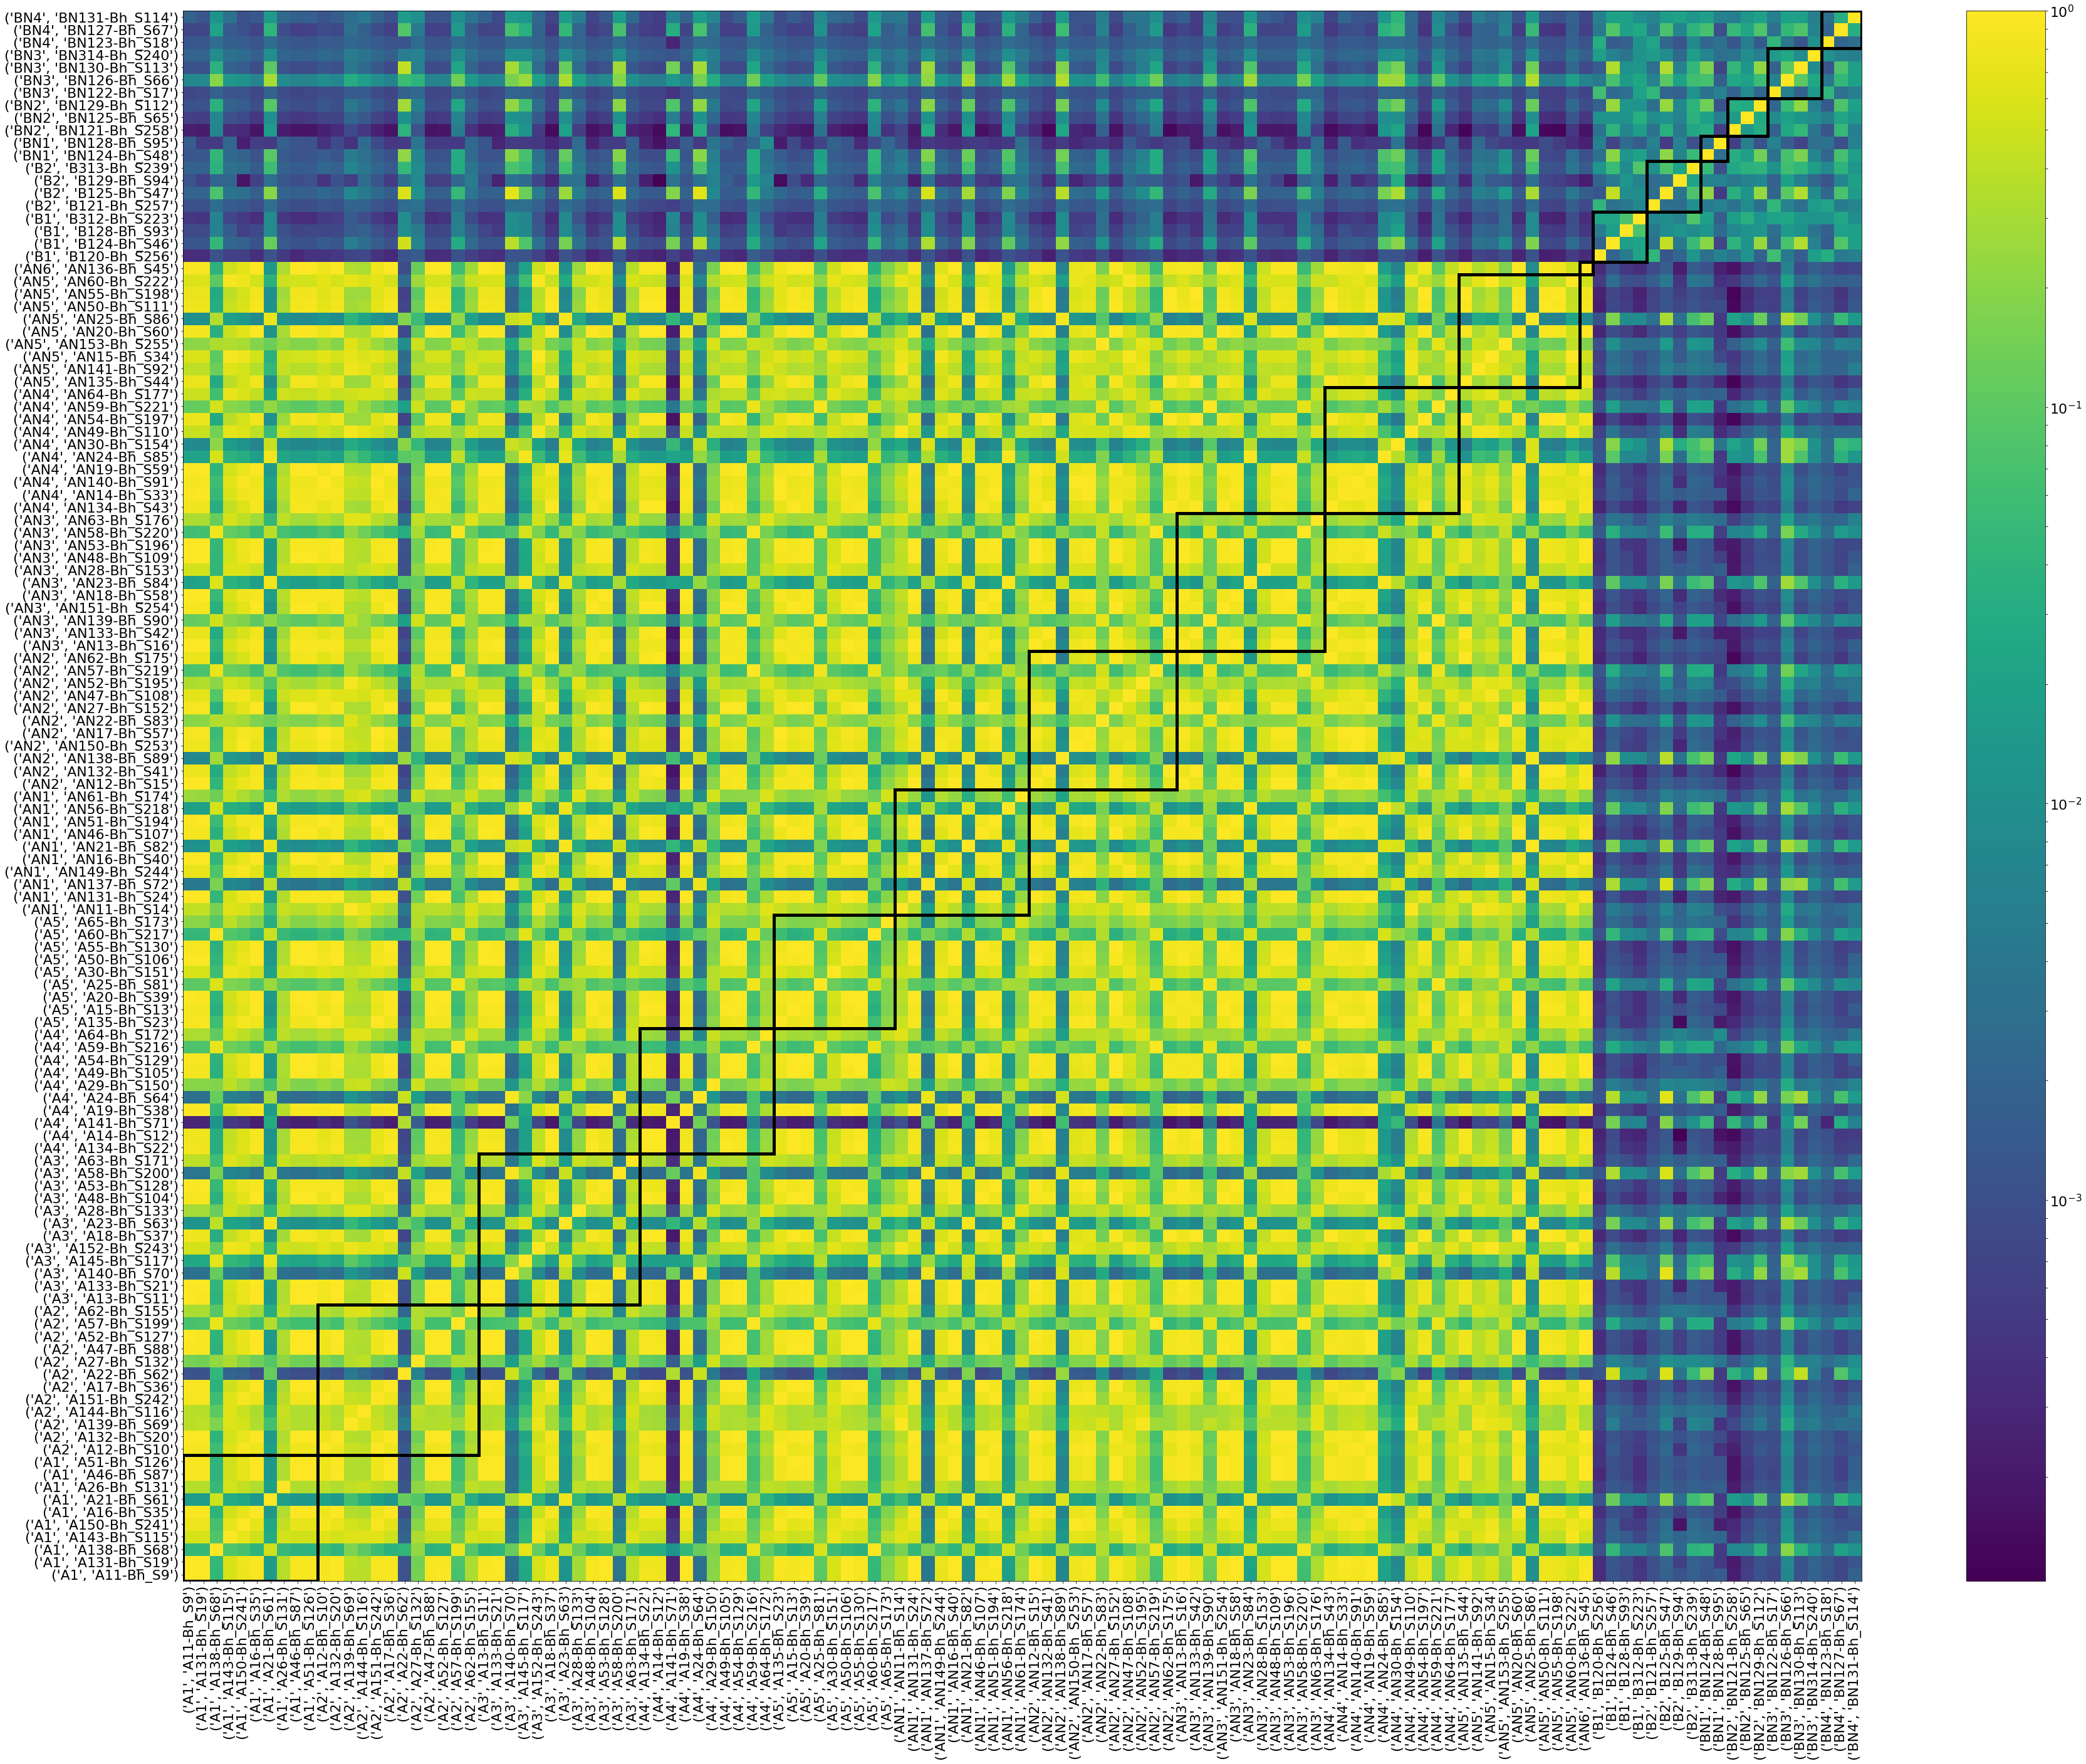

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.3463872626917758 0.33383988319394026
mean diff patient 0.274769024030247 0.3341764005798773
threshold 1.6114746263497561


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc8ff4ddd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc8f3ad860>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc8ff4de48>,
 'medians': [<matplotlib.lines.Line2D at 0x7fcc8fea8da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc8fea8438>,
 'means': []}

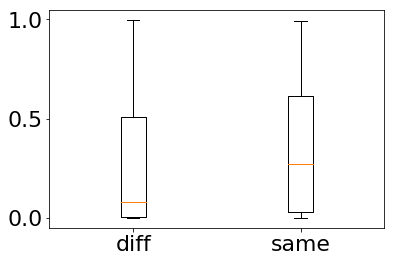

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

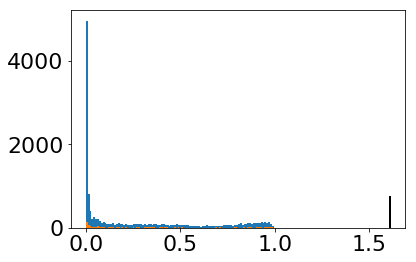

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote run40-similarity-IGH_MOUSE.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.00010942116205270302
max value: 1.0
Wrote run40-similarity-IGH_MOUSE-highlighted.pdf to disk


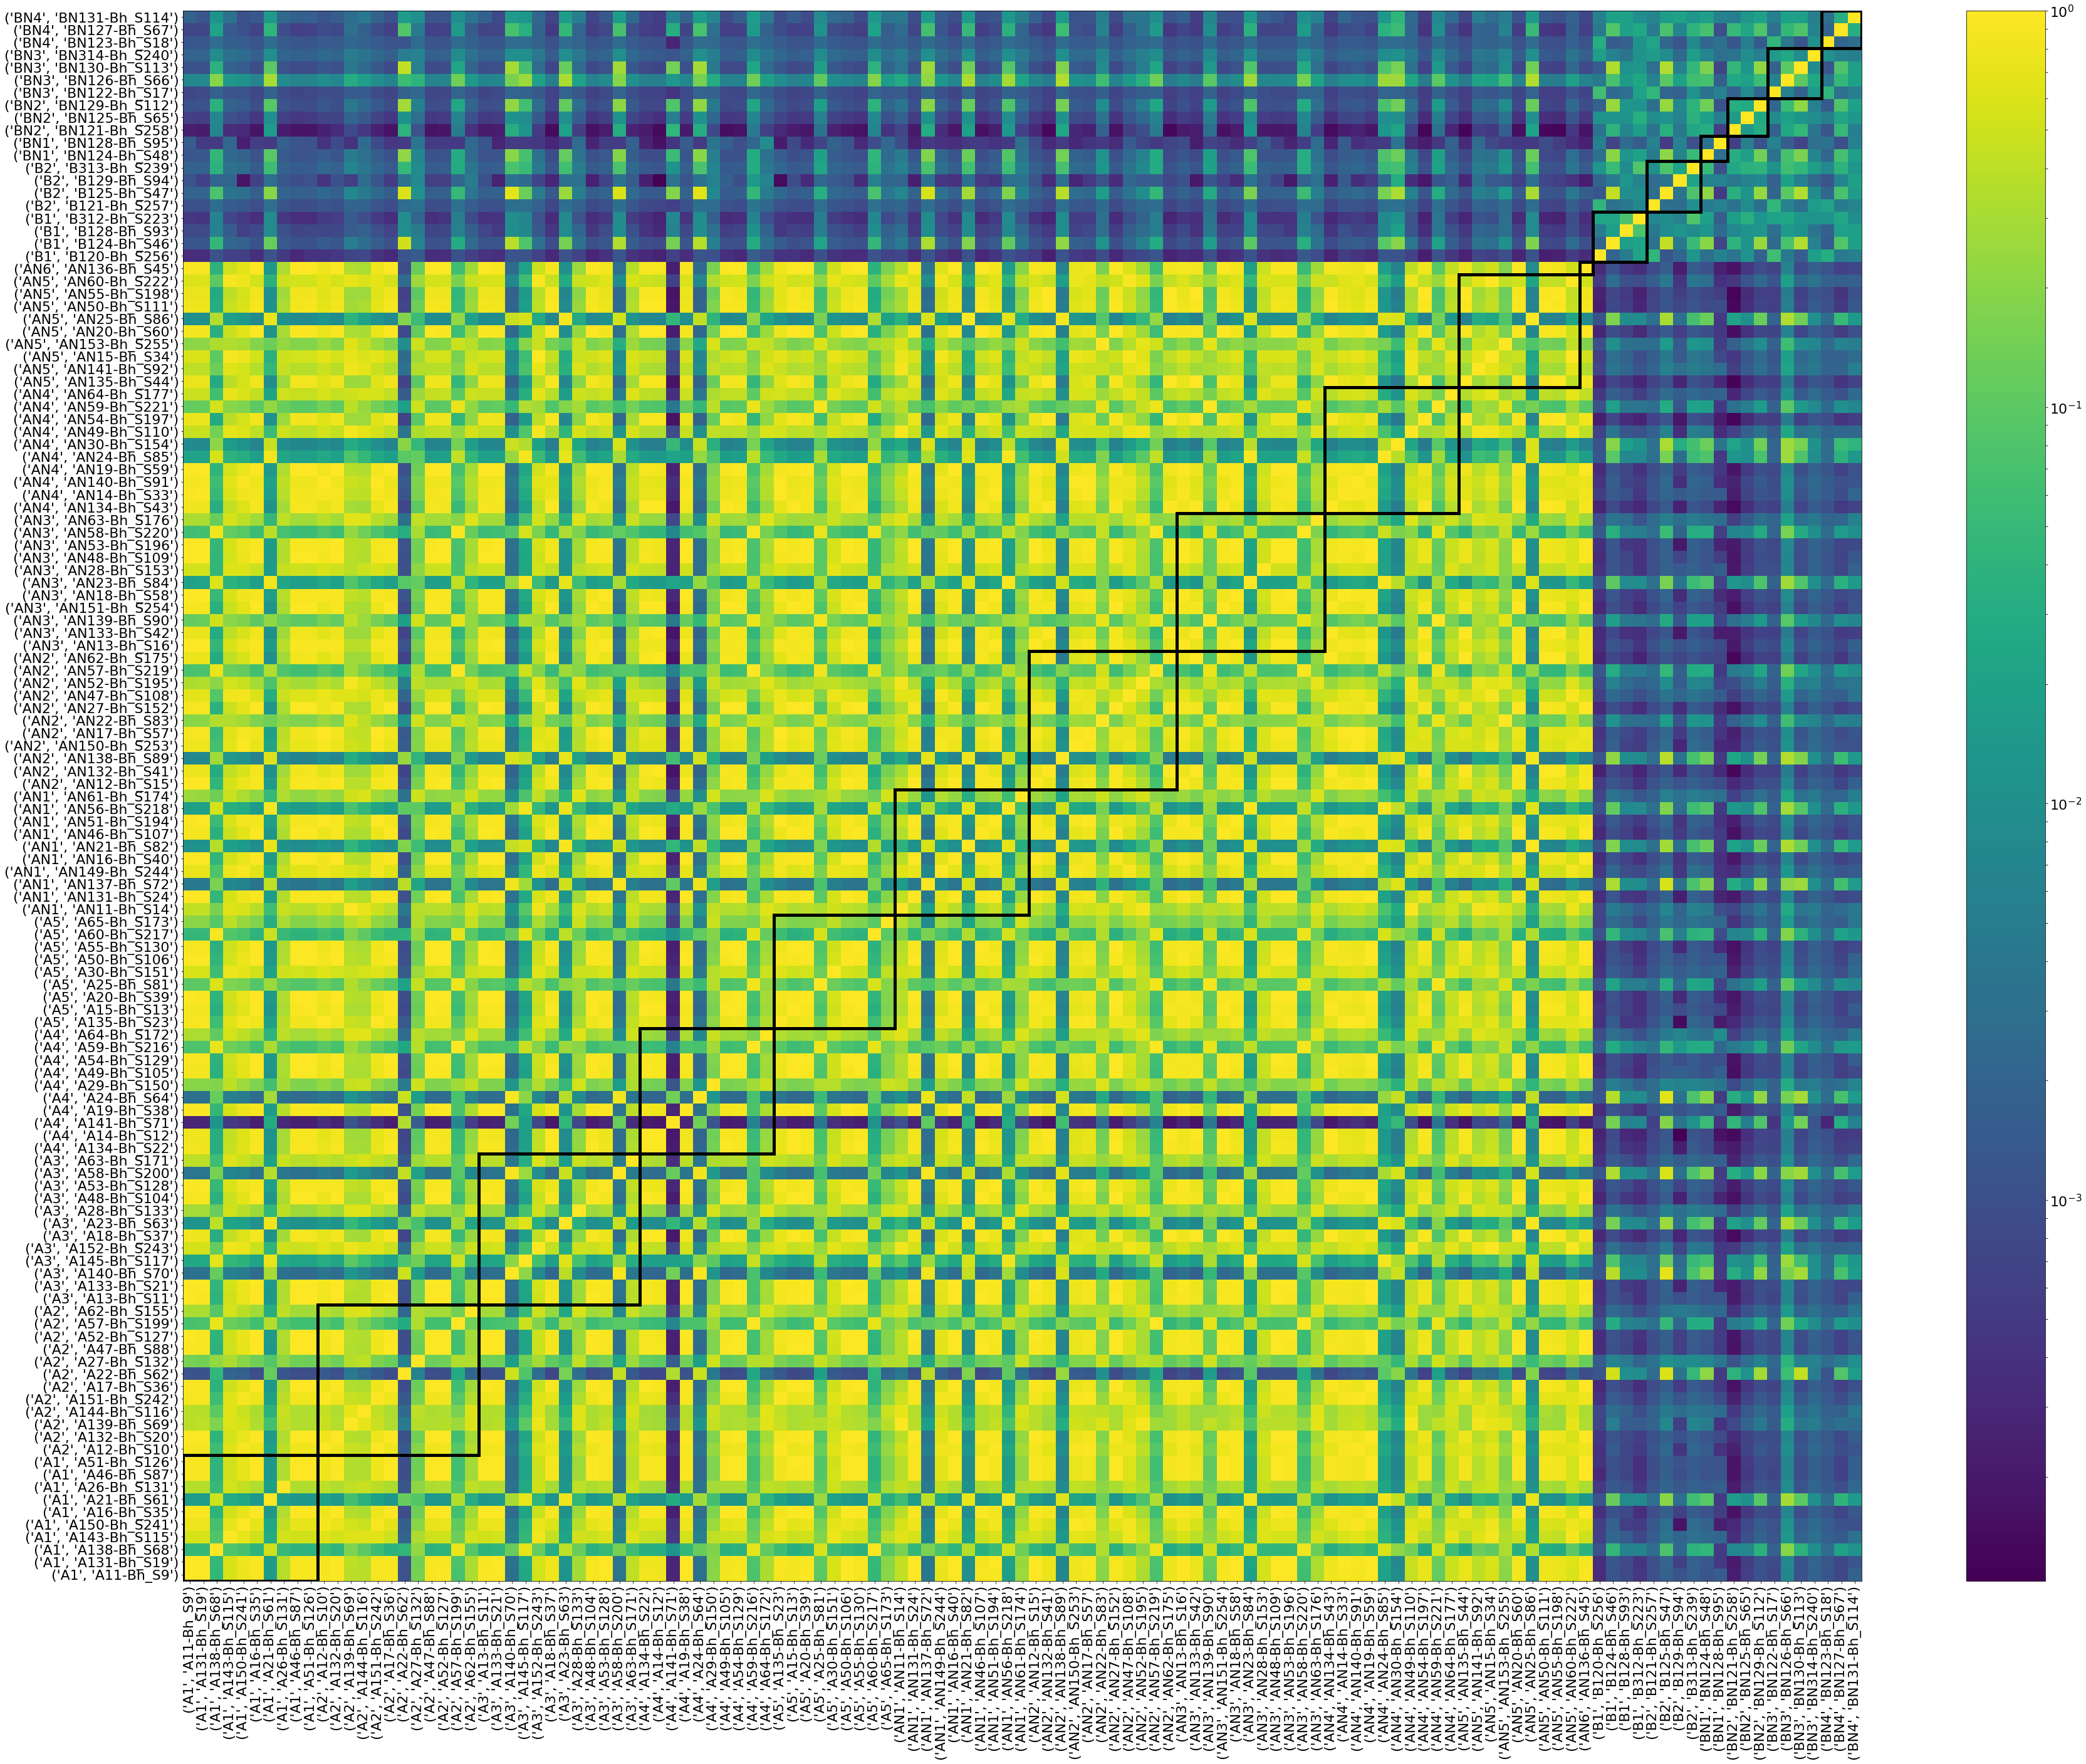

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)